In [75]:
""" thoughts from: https://taher-zadeh.com/outlier-detection-in-nonlinear-least-square-regression/
    ideas from the excellent pyastronomy Python library source code:
    http://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/index.html
"""

%matplotlib inline
import numpy as np

# first, let's generate some data
a = 1
b = 1
x = np.arange(0, 5, 0.05)
y_func = lambda x, a, b: a * np.exp(-1.0 * b * x)
y = y_func(x, a, b)

noise = np.random.normal(0, 0.02, len(y))

y = np.absolute(y + noise)

for u in np.arange(0, len(x), len(x) / 10):
    y[u] = 1.5 * np.random.random()


(0, 5)

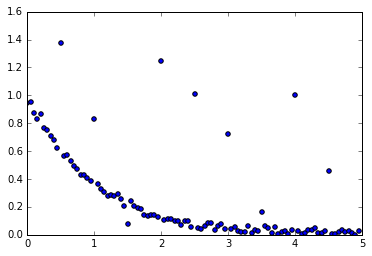

In [76]:
# let's take a quick look at our data
from matplotlib import pyplot as plt
plt.scatter(x,y)
plt.ylim(0,1.6)
plt.xlim(0,5)

In [77]:
# Now let's implement the Generalized Extreme Studentized Deviant (ESD) Test
from scipy.stats import norm


def generalized_esd_test(x, max_outlier, alpha=0.05, full_output=False):
    # the maximum number of outliers
    xmasked = np.ma.array(x)
    n = len(xmasked)
    R = []
    Lambda = []
    maxm = []

    for i in xrange(max_outlier + 1):
        xmean = xmasked.mean()
        xstd  = xmasked.std()

        # Maximum deviation
        max_dev = np.abs((xmasked - xmean) / xstd)
        maxm.append(np.argmax(max_dev))
        R.append(max_dev[maxm[-1]])

        if i >= 1:
            p = 1.0 - alpha / (2.0 * (n - i + 1))
            crit = norm.ppf(p, n - i - 1)
            Lambda.append((n - i) * crit / np.sqrt((n - i - 1 + crit**2) * (n - i + 1)))
        
        # mask that value and proceed
        xmasked[maxm[-1]] = np.ma.masked

    # Remove the first entry from R, which is of
    # no meaning for the test
    R.pop(-1)

    # find the number of outliers
    ofound = False
    for j in xrange(max_outlier - 1, -1, -1):
        if R[j] > Lambda[j]:
            ofound = True
            break

    # Prepare return value
    if ofound:
        if full_output:
            return i + 1, maxm[0: i + 1], R, Lambda, maxm
        else:
            return i + 1, maxm[0: i + 1]
    else:
        if full_output:
            return 0, [], R, L, maxm
        else:
            # No outliers could be detected
            return 0, []


In [72]:
# Now let's fit the data to a least-squares fit.

# https://python4mpia.github.io/fitting_data/least-squares-fitting.html

import scipy.optimize as optimization

x0 = np.zeros(100)

def diff_func(params, xdata, ydata):
    return (ydata - np.dot(xdata, params))

ls_fit = optimization.leastsq(diff_func, x0, args=(x, y))
print(ls_fit)

(array([  0.00000000e+00,  -1.94457896e+02,   6.38639118e+00,
        -1.89095368e+00,   1.26865547e+01,   3.41079296e-01,
        -5.16474755e+00,   6.95358132e-01,  -1.32681263e-01,
         2.61125753e+00,   1.70539648e-01,  -1.46614818e+00,
         2.95830050e-01,   2.09359193e-04,   1.12264712e+00,
         1.13693098e-01,  -6.59675569e-01,   1.76908353e-01,
         2.64270388e-02,   6.33146306e-01,   8.52698240e-02,
        -3.63605362e-01,   1.23251020e-01,   3.23049946e-02,
         4.11619448e-01,   6.82158720e-02,  -2.24590206e-01,
         9.35260224e-02,   3.26738978e-02,   2.92056815e-01,
         5.68465489e-02,  -1.49278647e-01,   7.49096279e-02,
         3.13529013e-02,   2.19850139e-01,   4.87256167e-02,
        -1.04112492e-01,   6.22603611e-02,   2.95500594e-02,
         1.72698057e-01,   4.26349120e-02,  -7.51949994e-02,
         5.31527448e-02,   2.76891738e-02,   1.40083022e-01,
         3.78976950e-02,  -5.57069139e-02,   4.63052965e-02,
         2.59219848e-02

In [78]:
# And we will take the difference between the data and the fit, and find the outliers there

ls_fit_diff = ls_fit[0] - y
num_found, bad_points = generalized_esd_test(ls_fit_diff, 20)
print(num_found, len(bad_points), bad_points)

(21, 21, [1, 4, 6, 2, 3, 9, 11, 40, 10, 16, 80, 50, 0, 14, 8, 20, 21, 60, 13, 26, 90])


(0, 5)

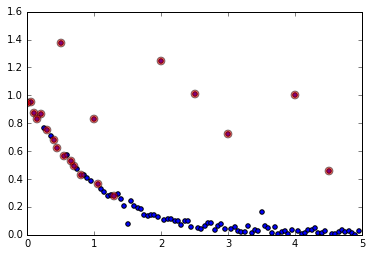

In [81]:
""" Let's plot the data again with:
        the original least squares fit line
        the outlier data points highlighted
        a new least squares fit, without the outliers
"""
plt.scatter(x,y)
plt.plot(x, ls_fit[0])
plt.scatter([x[j] for j in bad_points], [y[i] for i in bad_points], s=60, c='red', alpha=0.5)
plt.ylim(0,1.6)
plt.xlim(0,5)


